_Author: Christian Camilo Urcuqui López_

_Date: 25 july 2019_

# Anomaly Detection NSL-KDD dataset

In this notebook I'm going to explore the NSL-KDD dataset downloaded from the following URL:

https://www.unb.ca/cic/datasets/nsl.html

This work is divided in these sections:
+ [Introduction](#Introduction)
    - [Libraries](#Libraries)
+ [Data Exploratory](#Data-Exploratory)
+ [Modeling](#Modeling)
+ [Conclusions](#Conclusions)
+ [References](#References)

## Introduction

I
'm going to use the description described in the official dataset webpage, unb has proposed a new dataset from KDD'99 due its problems (some of related with reduntant records), the NLS's statistics are: 

__Statistics of redundant records in the KDD train set__

**Original records | Distinct records | Reduction rate**

+ Attacks: 3,925,650 | 262,178 | 93.32%
+ Normal: 972,781 | 812,814 | 16.44%
+ Total: 4,898,431 | 1,074,992 | 78.05%

__Statistics of redundant records in the KDD test set__

**Original records | Distinct records | Reduction rate**
+ Attacks: 250,436 | 29,378 | 88.26%
+ Normal: 60,591 | 47,911 | 20.92%
+ Total: 311,027 | 77,289 | 75.15%

The data has four attacks categories, they are:

+ DOS: denial-of-service, e.g. syn flood;
+ R2L: unauthorized access from a remote machine, e.g. guessing password;
+ U2R:  unauthorized access to local superuser (root) privileges, e.g., various ``buffer overflow'' attacks;
+ probing: surveillance and other probing, e.g., port scanning.

This is the features description:
```
    + duration | length (number of seconds) of the connection | continuous
    + protocol_type | type of the protocol, e.g. tcp, udp, etc. | discrete
    + service |	network service on the destination, e.g., http, telnet, etc. | discrete
    + src_bytes |	number of data bytes from source to destination |	continuous
    + dst_bytes |	number of data bytes from destination to source |	continuous
    + flag |	normal or error status of the connection |	discrete 
    + land |	1 if connection is from/to the same host/port; 0 otherwise |	discrete
    + wrong_fragment |	number of ``wrong'' fragments |	continuous
    + urgent |	number of urgent packets |	continuous
```
<center> Table 1: Basic features of individual TCP connections. </center>

```
    + hot |	number of ``hot'' indicators  |	continuous
    + num_failed_logins |	number of failed login attempts |	continuous
    + logged_in |	1 if successfully logged in; 0 otherwise |	discrete
    + num_compromised |	number of ``compromised'' conditions |	continuous
    + root_shell |	1 if root shell is obtained; 0 otherwise |	discrete
    + su_attempted |	1 if ``su root'' command attempted; 0 otherwise |	discrete
    + num_root |	number of ``root'' accesses |	continuous
    + num_file_creations |	number of file creation operations |	continuous
    + num_shells |	number of shell prompts |	continuous
    + num_access_files |	number of operations on access control files |	continuous
    + num_outbound_cmds	| number of outbound commands in an ftp session |	continuous
    + is_hot_login |	1 if the login belongs to the ``hot'' list; 0 otherwise |	discrete
    + is_guest_login |	1 if the login is a ``guest''login; 0 otherwise |	discrete    
```

<center>  Table 2: Content features within a connection suggested by domain knowledge. </center>

```
    + count |	number of connections to the same host as the current connection in the past two seconds |	continuous

Note: The following  features refer to these same-host connections.	

    + serror_rate |	% of connections that have ``SYN'' errors |	continuous
    + rerror_rate |	% of connections that have ``REJ'' errors |	continuous
    + same_srv_rate |	% of connections to the same service |	continuous
    + diff_srv_rate |	% of connections to different services |	continuous
    + srv_count |	number of connections to the same service as the current connection in the past two seconds |	continuous

Note: The following features refer to these same-service connections.	

    + srv_serror_rate |	% of connections that have ``SYN'' errors |	continuous
    + srv_rerror_rate |	% of connections that have ``REJ'' errors |	continuous
    + srv_diff_host_rate |	% of connections to different hosts |	continuous 
```

### Libraries

In [232]:
# libraries
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn import preprocessing

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
from sklearn.externals import joblib

## Data Exploratory

The file has 43 columns where the last one represents the difficulty level of the records in KDD dataset.

In [94]:
# let's load the datasets 
# these are the colnames described at http://kdd.ics.uci.edu/databases/kddcup99/task.html
col_names =["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent",
            "hot","num_failed_logins", "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login",            
            "count","srv_count", "serror_rate", "srv_serror_rate","rerror_rate","srv_rerror_rate",
            "same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels", "level"]
print(len(col_names))
df_train = pd.read_csv("../../Datasets/NSL-KDD/KDDTrain+.txt", names=col_names)

43


In [95]:
df_train.head().T

,0,1,2,3,4
duration,0,0,0,0,0
protocol_type,tcp,udp,tcp,tcp,tcp
service,ftp_data,other,private,http,http
flag,SF,SF,S0,SF,SF
src_bytes,491,146,0,232,199
dst_bytes,0,0,0,8153,420
land,0,0,0,0,0
wrong_fragment,0,0,0,0,0
urgent,0,0,0,0,0
hot,0,0,0,0,0


In [96]:
# for this analysis I will not use the last column 
df_train = df_train.iloc[:,:42].copy()

In [97]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
duration                       125973 non-null int64
protocol_type                  125973 non-null object
service                        125973 non-null object
flag                           125973 non-null object
src_bytes                      125973 non-null int64
dst_bytes                      125973 non-null int64
land                           125973 non-null int64
wrong_fragment                 125973 non-null int64
urgent                         125973 non-null int64
hot                            125973 non-null int64
num_failed_logins              125973 non-null int64
logged_in                      125973 non-null int64
num_compromised                125973 non-null int64
root_shell                     125973 non-null int64
su_attempted                   125973 non-null int64
num_root                       125973 non-null int64
num_file_creations             125973 

This data looks that doesn't have missing values, moreover, its dimensions are (125973, 42)

Let's see how is the proportion in the label column.

In [98]:
(df_train.labels.value_counts() / df_train.shape[0]) * 100

normal             53.458281
neptune            32.716534
satan               2.883951
ipsweep             2.856961
portsweep           2.326689
smurf               2.100450
nmap                1.185175
back                0.758893
teardrop            0.708088
warezclient         0.706501
pod                 0.159558
guess_passwd        0.042073
buffer_overflow     0.023815
warezmaster         0.015876
land                0.014289
imap                0.008732
rootkit             0.007938
loadmodule          0.007144
ftp_write           0.006351
multihop            0.005557
phf                 0.003175
perl                0.002381
spy                 0.001588
Name: labels, dtype: float64

As we can see around 53% of registers are normal, according to the paper `Dhanabal, L., & Shantharajah, S. P. (2015). A study on NSL-KDD dataset for intrusion detection system based on classification algorithms. International Journal of Advanced Research in Computer and Communication Engineering, 4(6), 446-452.` the four attacks and the values in 'labels' can be categorized as following:
+ U2R: rootkit, buffer_overflow, loadmodule, perl 
+ DoS: neptune, satan, smurf, back, teardrop, pod, land
+ Probe: ipsweep, portsweep, nmap, 
+ R2L: warezclient, guess_passwd, warezmaster, imap, ftp_write, multihop, phf, spy   

This is interesting because we can make new features that will be related to the attack types and another for malicious activities in general.

In [99]:
# I'm going to represent the malicious traffic as 1 and beningn as 0
att_types = []
type_tf = []
for i in range(len(df_train)):
    if df_train['labels'][i] == 'neptune':
        att_types.append("dos")
        type_tf.append(1)
    elif df_train['labels'][i] == 'normal':
        att_types.append("none")
        type_tf.append(0)
    elif df_train['labels'][i] == 'satan':
        att_types.append("dos")
        type_tf.append(1)
    elif df_train['labels'][i] == 'ipsweep':
        att_types.append("probe")
        type_tf.append(1)
    elif df_train['labels'][i] == 'portsweep':
        att_types.append("dos")
        type_tf.append(1)
    elif df_train['labels'][i] == 'smurf':
        att_types.append("dos")
        type_tf.append(1)
    elif df_train['labels'][i] == 'nmap':
        att_types.append("probe")
        type_tf.append(1)
    elif df_train['labels'][i] == 'back':
        att_types.append("dos")
        type_tf.append(1)
    elif df_train['labels'][i] == 'teardrop':
        att_types.append("dos")
        type_tf.append(1)
    elif df_train['labels'][i] == 'warezclient':
        att_types.append("r2l")
        type_tf.append(1)
    elif df_train['labels'][i] == 'land':
        att_types.append("dos")
        type_tf.append(1)
    elif df_train['labels'][i] == 'imap':
        att_types.append("r2l")
        type_tf.append(1)
    elif df_train['labels'][i] == 'rootkit':
        att_types.append("u2r")
        type_tf.append(1)
    elif df_train['labels'][i] == 'ftp_write':
        att_types.append("r2l")
        type_tf.append(1)
    elif df_train['labels'][i] == 'loadmodule':
        att_types.append("u2r")
        type_tf.append(1)
    elif df_train['labels'][i] == 'multihop':
        att_types.append("r2l")
        type_tf.append(1)
    elif df_train['labels'][i] == 'phf':
        att_types.append("r2l")
        type_tf.append(1)
    elif df_train['labels'][i] == 'perl':
        att_types.append("u2r")
        type_tf.append(1)
    elif df_train['labels'][i] == 'spy':
        att_types.append("r2l")
        type_tf.append(1)
    elif df_train['labels'][i] == 'guess_passwd':
        att_types.append("r2l")
        type_tf.append(1)
    elif df_train['labels'][i] == 'warezmaster':
        att_types.append("r2l")
        type_tf.append(1)
    elif df_train['labels'][i] == 'pod':
        att_types.append("dos")
        type_tf.append(1)
    elif df_train['labels'][i] == 'buffer_overflow':
        att_types.append("u2r")
        type_tf.append(1)
    elif df_train['labels'][i] == 'perl':
        att_types.append("u2r")
        type_tf.append(1)
serie = pd.Series(att_types)
df_train = df_train.assign(att_types=serie).copy()
del serie
serie = pd.Series(type_tf)
df_train = df_train.assign(type_tf=serie).copy()
del serie

In [102]:
# Has the dataset NAs?
df_train.isna().sum() 

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [103]:
(df_train.type_tf.value_counts() / df_train.shape[0]) * 100

0    53.458281
1    46.541719
Name: type_tf, dtype: float64

Well ... this is better, we have the two types of traffic with their meaning.

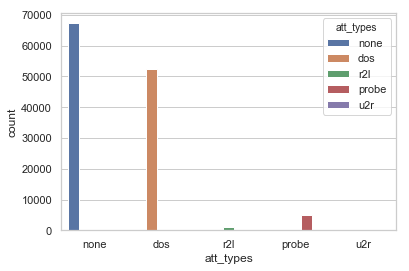

In [104]:
sns.countplot(x="att_types", data=df_train, hue="att_types")

In this data we have that the set of DoS is bigger than the others, and this is not good because our next analyses will be oriented to this type, in other words, if we train a model, it will be "good" for DoS detection.

In [105]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125973.0,45566.743000,5.870331e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125973.0,19779.114421,4.021269e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125973.0,0.000198,1.408607e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125973.0,0.022687,2.535300e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.000111,1.436603e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.204409,2.149968e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125973.0,0.001222,4.523914e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,125973.0,0.395736,4.890101e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,125973.0,0.279250,2.394204e+01,0.0,0.00,0.00,0.00,7.479000e+03


I have a doubt with the duration in 0, how is it meaning? a lot of features have 0 which mininum value.

In [106]:
# how many are the packets with 0 seconds
len(df_train[df_train.duration==0]) / df_train.shape[0]

0.9204750224254403

We have some discrete variables which are categorical or binary values, but others are saved in the dataframe as object, following I'm going to analyze the distribution of this data.

In [107]:
for i in df_train.columns:
    if df_train[i].dtypes == 'object' and (i not in ['labels', 'type_tf', 'att_types']):        
        print("Distribution of %s with %s are: \n%s " % (i, len(df_train[i]), df_train[i].value_counts()))

Distribution of protocol_type with 125973 are: 
tcp     102689
udp      14993
icmp      8291
Name: protocol_type, dtype: int64 
Distribution of service with 125973 are: 
http           40338
private        21853
domain_u        9043
smtp            7313
ftp_data        6860
eco_i           4586
other           4359
ecr_i           3077
telnet          2353
finger          1767
ftp             1754
auth             955
Z39_50           862
uucp             780
courier          734
bgp              710
whois            693
uucp_path        689
iso_tsap         687
time             654
imap4            647
nnsp             630
vmnet            617
urp_i            602
domain           569
ctf              563
csnet_ns         545
supdup           544
discard          538
http_443         530
               ...  
klogin           433
login            429
ldap             410
netbios_dgm      405
sunrpc           381
netbios_ssn      362
netstat          360
netbios_ns       347
ssh        

**It is not wear that if we are talking about DoS type FYN flood we have more TCP packets than UDP and ICMP.**
+ I think that the service feature is interesting to analyze (125973 values) where we can get insights about the type of each attack (__future work__)
+ I'm not really sure about the importance of the variable _flag_ (normal or error status of the connection) in this case. 

In [108]:
pd.crosstab(df_train.protocol_type, df_train.type_tf).style.highlight_max(color="green")

type_tf,0,1
protocol_type,,
icmp,1309,6982
tcp,53600,49089
udp,12434,2559


As I explained we can see through the last cross table that TCP packages are more in the malicious samples. My next hypothesis is related to package's weight from the attacks and the benign activities, in my opinion the DoS would be smaller.

Text(0.5, 1.0, 'beningn')

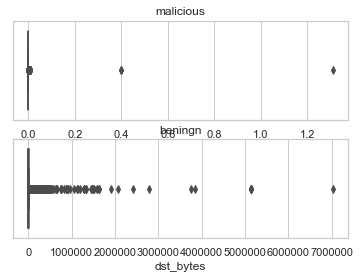

In [109]:
sns.set(style="whitegrid")
fig2 = plt.figure()
ax1 = fig2.add_subplot(2, 1, 1)
sns.boxplot(x=df_train[df_train.type_tf == 1].dst_bytes).set_title("malicious")
ax1 = fig2.add_subplot(2, 1, 2)
sns.boxplot(x=df_train[df_train.type_tf == 0].dst_bytes).set_title("beningn")

Text(0.5, 1.0, 'beningn')

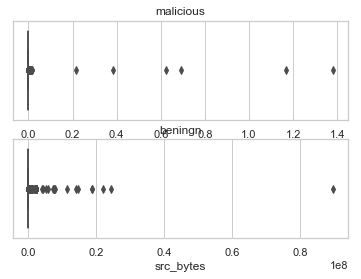

In [110]:
sns.set(style="whitegrid")
fig2 = plt.figure()
ax1 = fig2.add_subplot(2, 1, 1)
sns.boxplot(x=df_train[df_train.type_tf == 1].src_bytes).set_title("malicious")
ax1 = fig2.add_subplot(2, 1, 2)
sns.boxplot(x=df_train[df_train.type_tf == 0].src_bytes).set_title("beningn")

We have some outliers, how many are these?

In [111]:
print(len(df_train[df_train.dst_bytes > 0.1e6]))
print(len(df_train[df_train.src_bytes > 0.1e6]))

219
524


They aren't many, let's isolate them in another set.

In [236]:
isolate_set = df_train[(df_train.dst_bytes > 1e6) | (df_train.src_bytes > 1e6)][:].copy()
clean_set = df_train[(df_train.dst_bytes < 1e6) & (df_train.src_bytes < 1e6)][:].copy()

In [113]:
df_train.shape

(125973, 44)

In [114]:
clean_set.shape

(125619, 44)

Text(0.5, 1.0, 'beningn')

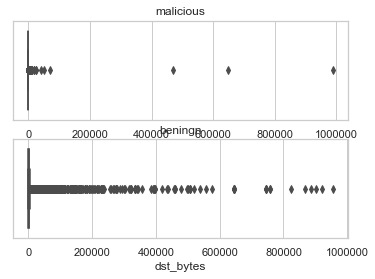

In [115]:
sns.set(style="whitegrid")
fig2 = plt.figure()
ax1 = fig2.add_subplot(2, 1, 1)
sns.boxplot(x=clean_set[clean_set.type_tf == 1].dst_bytes).set_title("malicious")
ax1 = fig2.add_subplot(2, 1, 2)
sns.boxplot(x=clean_set[clean_set.type_tf == 0].dst_bytes).set_title("beningn")

Text(0.5, 1.0, 'beningn')

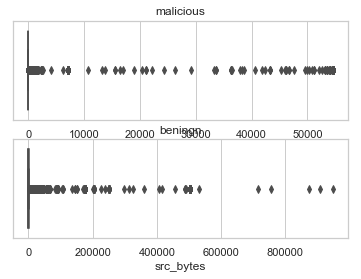

In [116]:
sns.set(style="whitegrid")
fig2 = plt.figure()
ax1 = fig2.add_subplot(2, 1, 1)
sns.boxplot(x=clean_set[clean_set.type_tf == 1].src_bytes).set_title("malicious")
ax1 = fig2.add_subplot(2, 1, 2)
sns.boxplot(x=clean_set[clean_set.type_tf == 0].src_bytes).set_title("beningn")

Definitely, both src and dst bytes are concentrated in zero with other values that are outliers, we should apply a normalization technique. 

In [117]:
columns_num = []
for i in clean_set.columns:
    if (clean_set[i].dtypes == 'int64') | (clean_set[i].dtypes == 'float64'): 
        columns_num.append(i)
columns_num.append('protocol_type')

In [239]:
scaler = preprocessing.RobustScaler()
columns = ['dst_bytes', 'src_bytes']
# the next line makes the scaler 
scaler = preprocessing.StandardScaler()
scaler.fit(clean_set.loc[:,columns])
scaledData = scaler.fit_transform(clean_set.loc[:,columns])
dst_sere = pd.Series(scaledData[:,0], name="dst_bytes")
src_sere = pd.Series(scaledData[:,1], name="src_bytes")

D:\Usuarios\rhaps\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Usuarios\rhaps\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Usuarios\rhaps\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [119]:
clean_set = pd.get_dummies(clean_set, columns=['protocol_type'], dummy_na=False).copy()

+ I made dummy variables for the protocol_type feature.
+ I applied a rubustscaler for two features.

## Modeling

I think I can use only the feature protocol_type to determine if a traffic is malicious or not, following I can improve the result researching other significant variables, let's train some classifiers with hyperparameters by default.

### Experiment 1

In [191]:
np.random.seed(128)
# I will use a hold-out due the proportion around 50% for the dependend variable
X_train, X_test, y_train, y_test = train_test_split(clean_set.iloc[:,43:46], clean_set.type_tf, test_size=0.20)

In [195]:
# decision tree model
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
# accuracy
accuracy = accuracy_score(pred, y_test)
print(clf)
print(accuracy)
print(classification_report(pred, y_test, labels=None))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.576540359815316
              precision    recall  f1-score   support

           0       0.98      0.56      0.71     23474
           1       0.12      0.84      0.21      1650

   micro avg       0.58      0.58      0.58     25124
   macro avg       0.55      0.70      0.46     25124
weighted avg       0.92      0.58      0.68     25124



In [197]:
# Naive Bayes algorithm
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# pred
pred = gnb.predict(X_test)

# accuracy
accuracy = accuracy_score(pred, y_test)
print("naive_bayes")
print(accuracy)
print(classification_report(pred, y_test, labels=None))

naive_bayes
0.576540359815316
              precision    recall  f1-score   support

           0       0.98      0.56      0.71     23474
           1       0.12      0.84      0.21      1650

   micro avg       0.58      0.58      0.58     25124
   macro avg       0.55      0.70      0.46     25124
weighted avg       0.92      0.58      0.68     25124



With only one feature we got an accuracy of 57% (like the baseline), but the precision is really bad in malicious activites, in other words we have problems wih false positives.

### Experiment 2

This experiment is going to use three features (protocol, src bytes and dst bytes) because as we saw TCP is used in DoS SYN and in those attacks the number of bytes is not higher than the normal connections and communications.    

In [188]:
df_ex2 = clean_set.iloc[:,43:46].copy()
df_ex2 = df_ex2.assign(dst_bytes = dst_sere.values).assign(src_bytes=src_sere.values).copy()
df_ex2.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,dst_bytes,src_bytes
0,0,1,0,0.000000,1.637363
1,0,0,1,0.000000,0.373626
2,0,1,0,0.000000,-0.161172
3,0,1,0,15.709056,0.688645
4,0,1,0,0.809249,0.567766


In [190]:
np.random.seed(128)
# I will use a hold-out due the proportion around 50% for the dependend variable
X_train, X_test, y_train, y_test = train_test_split(ok, clean_set.type_tf, test_size=0.20)

In [233]:
# decision tree model
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
# accuracy
accuracy = accuracy_score(pred, y_test)
print(clf)
print(accuracy)
print("Kappa    : ", cohen_kappa_score(y_test, pred))
print(classification_report(pred, y_test, labels=None))
print("confusion matrix")
confusion_matrix(y_test, pred)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.972058589396593
Kappa    :  0.9440785716220281
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     12697
           1       1.00      0.94      0.97     12427

   micro avg       0.97      0.97      0.97     25124
   macro avg       0.97      0.97      0.97     25124
weighted avg       0.97      0.97      0.97     25124

confusion matrix


array([[12682,   687],
       [   15, 11740]], dtype=int64)

In [234]:
# Naive Bayes algorithm
gnb = GaussianNB()
gnb.fit(X_train, y_train)
# pred
pred = gnb.predict(X_test)
# accuracy
accuracy = accuracy_score(pred, y_test)
print("naive_bayes")
print(accuracy)
print(classification_report(pred, y_test, labels=None))
print("Kappa    : ", cohen_kappa_score(y_test, pred))
print("confusion matrix")
confusion_matrix(y_test, pred)

naive_bayes
0.5692962903996179
              precision    recall  f1-score   support

           0       0.24      0.83      0.37      3914
           1       0.94      0.52      0.67     21210

   micro avg       0.57      0.57      0.57     25124
   macro avg       0.59      0.67      0.52     25124
weighted avg       0.83      0.57      0.63     25124

Kappa    :  0.175075198998342
confusion matrix


array([[ 3231, 10138],
       [  683, 11072]], dtype=int64)

In [235]:
# kneighbors algorithm
neigh = KNeighborsClassifier(n_neighbors=2)
neigh_two = KNeighborsClassifier(n_neighbors=3)
neigh_three = KNeighborsClassifier(n_neighbors=4)
neigh_four = KNeighborsClassifier(n_neighbors=6)

neigh.fit(X_train, y_train)
neigh_two.fit(X_train, y_train)
neigh_three.fit(X_train, y_train)
neigh_four.fit(X_train, y_train)

pred = neigh.predict(X_test)
pred_two = neigh_two.predict(X_test)
pred_three = neigh_three.predict(X_test)
pred_four = neigh_four.predict(X_test)
# accuracy
accuracy = accuracy_score(pred, y_test)
accuracy_two = accuracy_score(pred_two, y_test)
accuracy_three = accuracy_score(pred_three, y_test)
accuracy_four = accuracy_score(pred_four, y_test)

print("kneighbors 2")
print(accuracy)
print(classification_report(pred, y_test, labels=None))
print("Kappa    : ", cohen_kappa_score(y_test, pred))
print("")
print("kneighbors 3")
print(accuracy_two)
print(classification_report(pred_two, y_test, labels=None))
print("Kappa    : ", cohen_kappa_score(y_test, pred))
print("")
print("kneighbors 4")
print(accuracy_three)
print(classification_report(pred_three, y_test, labels=None))
print("Kappa    : ", cohen_kappa_score(y_test, pred))
print("kneighbors 6")
print(accuracy_four)
print(classification_report(pred_four, y_test, labels=None))
print("Kappa    : ", cohen_kappa_score(y_test, pred))

kneighbors 2
0.9721779971342143
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     12718
           1       1.00      0.95      0.97     12406

   micro avg       0.97      0.97      0.97     25124
   macro avg       0.97      0.97      0.97     25124
weighted avg       0.97      0.97      0.97     25124

Kappa    :  0.944311567415589

kneighbors 3
0.9721779971342143
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     12696
           1       1.00      0.94      0.97     12428

   micro avg       0.97      0.97      0.97     25124
   macro avg       0.97      0.97      0.97     25124
weighted avg       0.97      0.97      0.97     25124

Kappa    :  0.944311567415589

kneighbors 4
0.9719789842381786
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     12717
           1       1.00      0.95      0.97     12407

   micro avg       0.97 

We have either the models based on decision tree and KNN are good with 97% in accuracy and with a low rate in false positives (precision 100% in malicious network traffic).

In [212]:
# For this case, I'm going to save the model based on dt due its kappa is 0.94
joblib.dump(clf, 'defense.joblib')
clean_set.to_csv("clean.csv")

['defense.joblib']

## Testing

In [14]:
clean_set = pd.read_csv("clean.csv", index_col=0)
clf = load('defense.joblib') 

In [248]:
col_names =["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent",
            "hot","num_failed_logins", "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login",            
            "count","srv_count", "serror_rate", "srv_serror_rate","rerror_rate","srv_rerror_rate",
            "same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels", "level"]
testing = pd.read_csv("../../Datasets/NSL-KDD/KDDTest-21.txt", names=col_names)

In [218]:
testing.isna().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [219]:
testing.shape

(11850, 43)

In [249]:
"""
The idea is to have the next code lines in a pre-processing method 
"""

testing = testing.iloc[:,:42].copy()

# I'm going to represent the malicious traffic as 1 and beningn as 0
att_types = []
type_tf = []
for i in range(len(testing)):
    if testing['labels'][i] == 'neptune':
        att_types.append("dos")
        type_tf.append(1)
    elif testing['labels'][i] == 'normal':
        att_types.append("none")
        type_tf.append(0)
    elif testing['labels'][i] == 'satan':
        att_types.append("dos")
        type_tf.append(1)
    elif testing['labels'][i] == 'ipsweep':
        att_types.append("probe")
        type_tf.append(1)
    elif testing['labels'][i] == 'portsweep':
        att_types.append("dos")
        type_tf.append(1)
    elif testing['labels'][i] == 'smurf':
        att_types.append("dos")
        type_tf.append(1)
    elif testing['labels'][i] == 'nmap':
        att_types.append("probe")
        type_tf.append(1)
    elif testing['labels'][i] == 'back':
        att_types.append("dos")
        type_tf.append(1)
    elif testing['labels'][i] == 'teardrop':
        att_types.append("dos")
        type_tf.append(1)
    elif testing['labels'][i] == 'warezclient':
        att_types.append("r2l")
        type_tf.append(1)
    elif testing['labels'][i] == 'land':
        att_types.append("dos")
        type_tf.append(1)
    elif testing['labels'][i] == 'imap':
        att_types.append("r2l")
        type_tf.append(1)
    elif testing['labels'][i] == 'rootkit':
        att_types.append("u2r")
        type_tf.append(1)
    elif testing['labels'][i] == 'ftp_write':
        att_types.append("r2l")
        type_tf.append(1)
    elif testing['labels'][i] == 'loadmodule':
        att_types.append("u2r")
        type_tf.append(1)
    elif testing['labels'][i] == 'multihop':
        att_types.append("r2l")
        type_tf.append(1)
    elif testing['labels'][i] == 'phf':
        att_types.append("r2l")
        type_tf.append(1)
    elif testing['labels'][i] == 'perl':
        att_types.append("u2r")
        type_tf.append(1)
    elif testing['labels'][i] == 'spy':
        att_types.append("r2l")
        type_tf.append(1)
    elif testing['labels'][i] == 'guess_passwd':
        att_types.append("r2l")
        type_tf.append(1)
    elif testing['labels'][i] == 'warezmaster':
        att_types.append("r2l")
        type_tf.append(1)
    elif testing['labels'][i] == 'pod':
        att_types.append("dos")
        type_tf.append(1)
    elif testing['labels'][i] == 'buffer_overflow':
        att_types.append("u2r")
        type_tf.append(1)
    elif testing['labels'][i] == 'perl':
        att_types.append("u2r")
        type_tf.append(1)
            
serie = pd.Series(att_types)
df_testing = testing.assign(att_types=serie).copy()
del serie
serie = pd.Series(type_tf)
df_testing = df_testing.assign(type_tf=serie).copy()
del serie


In [250]:
# we have 3740 registers that does not have a label to analyze... I will isolate them
df_testing.type_tf.isna().sum()

3740

In [244]:
isolate_test = df_testing[df_testing.type_tf.isna()].copy()
isolate_test.shape

(3740, 44)

In [253]:
df_testing_clean = df_testing.dropna().copy()
df_testing_clean.shape

(8110, 44)

In [254]:
# I will use the scaler previously made in the training phase ... the idea is to have the same distribution
columns = ['dst_bytes', 'src_bytes']
scaledData = scaler.transform(df_testing_clean.loc[:,columns])

dst_sere = pd.Series(scaledData[:,0], name="dst_bytes")
src_sere = pd.Series(scaledData[:,1], name="src_bytes")

df_testingX = pd.get_dummies(df_testing_clean, columns=['protocol_type'], dummy_na=False).copy()

df_testingX = df_testingX.iloc[:,43:46].copy()
df_testingX = df_testingX.assign(dst_bytes = dst_sere.values).assign(src_bytes=src_sere.values).copy()
df_testingX.head()

D:\Usuarios\rhaps\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,dst_bytes,src_bytes
0,0,1,0,0.046538,-0.074950
1,0,0,1,-0.130615,-0.079033
2,0,1,0,-0.127400,-0.081460
3,0,0,1,-0.126597,-0.078536
4,0,1,0,-0.130615,-0.081460


In [257]:
pred = clf.predict(df_testingX)
# accuracy
accuracy = accuracy_score(pred, df_testing_clean.type_tf)
print(clf)
print(accuracy)
print(classification_report(pred, df_testing_clean.type_tf, labels=None))
print("confusion matrix")
confusion_matrix(df_testing_clean.type_tf, pred)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.30036991368680643
              precision    recall  f1-score   support

           0       0.93      0.27      0.41      7534
           1       0.07      0.75      0.13       576

   micro avg       0.30      0.30      0.30      8110
   macro avg       0.50      0.51      0.27      8110
weighted avg       0.87      0.30      0.39      8110

confusion matrix


array([[2006,  146],
       [5528,  430]], dtype=int64)

## Conclusions

+ Both protocol type and the weight of the transmition allowed to train a model which in the tranining phase had good results, but in the test set isn't worked well. 

__future work__

+ It is neccesary to evaluate other features like the service.
+ Apply and exploratory data analysis to the test set in oder to know the differences to the training insights.


## References

+ M. Tavallaee, E. Bagheri, W. Lu, and A. Ghorbani, “A Detailed Analysis of the KDD CUP 99 Data Set,” Submitted to Second IEEE Symposium on Computational Intelligence for Security and Defense Applications (CISDA), 2009.

https://github.com/CynthiaKoopman/Network-Intrusion-Detection/blob/master/DecisionTree_IDS.ipynb

https://github.com/vinayakumarr/Network-Intrusion-Detection

https://github.com/thinline72/nsl-kdd

https://www.ee.ryerson.ca/~bagheri/papers/cisda.pdf